# Project 3 - Peter Laffey

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
import sklearn


In [4]:
df_raw = pd.read_csv("admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [5]:
# frequency table for prestige and whether or not someone was admitted
prest_ft = pd.crosstab(index=df_raw['prestige'], columns = "count")
prest_ft

col_0,count
prestige,
1.0,61
2.0,150
3.0,121
4.0,67


In [6]:
admit_ft = pd.crosstab(index=df_raw['admit'], columns = "count")
admit_ft

col_0,count
admit,
0,273
1,127


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [7]:
df_dummies = df_raw.join(pd.get_dummies(df['prestige'], prefix='prestige'))
df_dummies.head()

,admit,gre,gpa,prestige,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,3.0,0.0,0.0,1.0,0.0
1,1,660.0,3.67,3.0,0.0,0.0,1.0,0.0
2,1,800.0,4.00,1.0,1.0,0.0,0.0,0.0
3,1,640.0,3.19,4.0,0.0,0.0,0.0,1.0
4,0,520.0,2.93,4.0,0.0,0.0,0.0,1.0


#### 2.2 When modeling our class variables, how many do we need? 



Answer: We will need gre, gpa, and 3 of the 4 prestige dummies to avoid colinearity problems

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [8]:
cols_to_keep = ['admit', 'gre', 'gpa', 'prestige_1.0']
handCalc = df_dummies[cols_to_keep]
print handCalc.head()

   admit    gre   gpa  prestige_1.0
0      0  380.0  3.61           0.0
1      1  660.0  3.67           0.0
2      1  800.0  4.00           1.0
3      1  640.0  3.19           0.0
4      0  520.0  2.93           0.0


In [9]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitte
pd.crosstab(handCalc['admit'], handCalc['prestige_1.0'])

prestige_1.0,0.0,1.0
admit,,
0,243,28
1,93,33


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [10]:
a = 33.0/28.0 #approx 1.178 to 1

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [11]:
b = 93.0/243.0 #approx .382 to 1

#### 3.3 Calculate the odds ratio

In [12]:
print a/b

3.07949308756


#### 3.4 Write this finding in a sentenance: 

Answer: Our OR is greater than one, thus we can conclude that attending a number 1 ranked college is associated with being admitted to grad school

#### 3.5 Print the cross tab for prestige_4

In [13]:
pd.crosstab(df_dummies['admit'], df_dummies['prestige_4.0'])

prestige_4.0,0.0,1.0
admit,,
0,216,55
1,114,12


#### 3.6 Calculate the OR 

In [14]:
odds_ratio = (12.0/55)/(114.0/216)
print odds_ratio


0.413397129187


#### 3.7 Write this finding in a sentence

Answer: The odds ratio is less than one, so we conclude that attending a low ranked school is not associated with being admitted to grad school. 

## Part 4. Analysis

In [15]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(df_dummies.ix[:, 'prestige_2.0':])
print data.head()

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61           0.0           1.0           0.0
1      1  660.0  3.67           0.0           1.0           0.0
2      1  800.0  4.00           0.0           0.0           0.0
3      1  640.0  3.19           0.0           0.0           1.0
4      0  520.0  2.93           0.0           0.0           1.0


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [16]:
# manually add the intercept
data['intercept'] = 1.0
data.head()


,admit,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
0,0,380.0,3.61,0.0,1.0,0.0,1.0
1,1,660.0,3.67,0.0,1.0,0.0,1.0
2,1,800.0,4.00,0.0,0.0,0.0,1.0
3,1,640.0,3.19,0.0,0.0,1.0,1.0
4,0,520.0,2.93,0.0,0.0,1.0,1.0


#### 4.1 Set the covariates to a variable called train_cols

In [17]:
train_cols = data.ix[:,'gre':]
train_cols.describe()

,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.0
mean,587.858942,3.392242,0.372796,0.304786,0.168766,1.0
std,115.717787,0.380208,0.484159,0.460898,0.375017,0.0
min,220.000000,2.260000,0.000000,0.000000,0.000000,1.0
25%,520.000000,3.130000,0.000000,0.000000,0.000000,1.0
50%,580.000000,3.400000,0.000000,0.000000,0.000000,1.0
75%,660.000000,3.670000,1.000000,1.000000,0.000000,1.0
max,800.000000,4.000000,1.000000,1.000000,1.000000,1.0


In [18]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()

#### 4.2 Fit the model

In [19]:
lm.fit(train_cols, data['admit'])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 4.3 Print the summary results

In [20]:
print lm.coef_
print lm.intercept_

[[ 0.00188666  0.32452811 -0.6200671  -1.16988125 -1.3847737  -1.09518905]]
[-1.09518905]


#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [21]:
 
params =np.exp(lm.coef_)
print params
print np.exp(lm.intercept_)

[[ 1.00188844  1.38337769  0.53790834  0.3104038   0.25038045  0.33447637]]
[ 0.33447637]


In [24]:
#conf.columns = ['params'] # not sure how to do this??

NameError: name 'conf' is not defined

#### 4.5 Interpret the OR of Prestige_2

Answer: 

#### 4.6 Interpret the OR of GPA

Answer: 

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [25]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [26]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
combos.head()

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


,0,1,2,3
0,220.0,2.260000,1.0,1.0
1,220.0,2.260000,2.0,1.0
2,220.0,2.260000,3.0,1.0
3,220.0,2.260000,4.0,1.0
4,220.0,2.453333,1.0,1.0


#### 5.1 Recreate the dummy variables

In [27]:
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'admit']
combos.head()
combos_dummies = pd.get_dummies(combos['prestige'], prefix='prestige')
combos_dummies.head()
# keep only what we need for making predictions
combo_new = combos.join(combos_dummies.ix[:, 'prestige_2.0':])
del combo_new['prestige']
del combo_new['admit']
#combo_new.head()
# manually add the intercept
combo_new['intercept'] = 1.0
combo_new.describe()




,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0,intercept
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.0
mean,510.000000,3.130000,0.250000,0.250000,0.250000,1.0
std,185.334387,0.556003,0.433555,0.433555,0.433555,0.0
min,220.000000,2.260000,0.000000,0.000000,0.000000,1.0
25%,348.888889,2.646667,0.000000,0.000000,0.000000,1.0
50%,510.000000,3.130000,0.000000,0.000000,0.000000,1.0
75%,671.111111,3.613333,0.250000,0.250000,0.250000,1.0
max,800.000000,4.000000,1.000000,1.000000,1.000000,1.0


#### 5.2 Make predictions on the enumerated dataset

In [28]:
actuals = lm.predict(combo_new) 
probas = lm.predict_proba(combo_new)


from sklearn.metrics import classification_report
print classification_report(actuals, combos['admit'])


             precision    recall  f1-score   support

          0       0.00      0.00      0.00       367
          1       0.08      1.00      0.15        33

avg / total       0.01      0.08      0.01       400



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
sklearn.metrics.confusion_matrix(actuals, combos['admit'])

array([[  0, 367],
       [  0,  33]])

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, auc

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/ranking.py:530: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


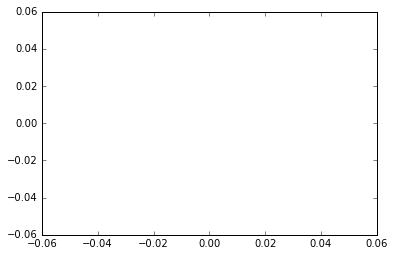

In [31]:
plt.plot(roc_curve(combos[['admit']], probas[:,1])[0], roc_curve(combos[['admit']], probas[:,1])[1])

#### 5.3 Interpret findings for the last 4 observations

Answer: It would seem that every single prediction is incorrect.

### 5.4: going to use train/test/split here instead 

In [35]:
#using the original admissions data set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(\
            train_cols, data['admit'], test_size=0.33, random_state=42)
logmodel = LogisticRegression()
#fit the model on the training set
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
#predict on test set
actuals = logmodel.predict(X_test) 
probas = logmodel.predict_proba(X_test)

In [40]:
# The coefficients
print('Coefficients:', logmodel.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((logmodel.predict(X_test) - y_test) ** 2))
# Explained variance score
print('Variance score: %.2f' % logmodel.score(X_test, y_test))

('Coefficients:', array([[ 0.00214522,  0.42359132, -0.14228612, -0.92790085, -1.09804434,
        -1.56747136]]))
Residual sum of squares: 0.40
Variance score: 0.60


In [41]:
# confusion matrix - not too bad!
sklearn.metrics.confusion_matrix(actuals, y_test)

array([[77, 41],
       [ 3, 11]])

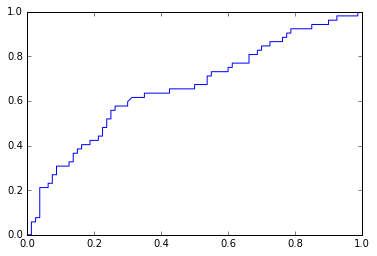

In [42]:
#plot the roc curve 
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.